<a href="https://colab.research.google.com/github/11jolek11/BigDataHCVproject/blob/main/BigDataHCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
# /content/drive/MyDrive/Colab Notebooks/datasets/hcvdat0.csv


In [72]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


In [73]:
# hcv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/hcvdat0.csv', header=0)
hcv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/hcvdat0-synthetic1800.csv', header=0)
hcv[hcv.isna().any(axis=1)]

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
4,0=Blood Donor,43,m,49.3,51.7,28.0,22.1,7.4,13.80,NaN,86.0,19.7,63.2
5,1=Hepatitis,69,m,43.0,37.0,3.9,113.8,50.0,7.00,3.98,136.1,144.2,NaN
22,0=Blood Donor,55,m,48.3,NaN,69.2,135.4,23.8,13.71,4.47,71.0,31.1,69.1
50,3=Cirrhosis,42,f,24.9,NaN,102.2,90.3,12.0,5.65,4.10,71.0,61.1,69.5
62,2=Fibrosis,68,m,37.1,NaN,7.2,30.8,12.0,2.23,3.01,105.0,128.2,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,0=Blood Donor,52,m,36.6,53.8,NaN,20.8,6.5,8.51,4.20,86.0,24.3,72.9
1752,3=Cirrhosis,48,m,49.0,NaN,24.2,64.0,40.0,8.50,NaN,118.2,23.8,81.0
1769,1=Hepatitis,55,m,29.0,NaN,2.4,36.7,33.3,13.56,5.44,60.0,35.0,53.2
1772,0s=suspect Blood Donor,59,m,NaN,67.6,20.5,83.6,12.0,9.13,4.86,70.0,70.0,70.4


In [74]:
hcv["Category"].value_counts()

0=Blood Donor             1501
3=Cirrhosis                103
2=Fibrosis                  80
1=Hepatitis                 78
0s=suspect Blood Donor      38
Name: Category, dtype: int64

In [75]:
indexes_to_delete = hcv.index[hcv["Category"] == "0=Blood Donor"]
drop_indices = np.random.choice(indexes_to_delete, 1200, replace=False)
hcv.drop(drop_indices, inplace=True)

In [76]:
hcv["Category"].value_counts()

0=Blood Donor             301
3=Cirrhosis               103
2=Fibrosis                 80
1=Hepatitis                78
0s=suspect Blood Donor     38
Name: Category, dtype: int64

<Axes: xlabel='Category', ylabel='count'>

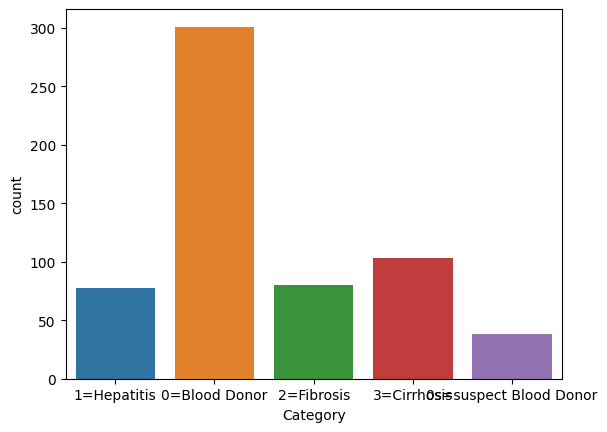

In [77]:
sns.countplot(x=hcv["Category"])

<ipython-input-78-84fec86dbd3a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hcv.corr(), annot=True, cmap='rainbow')


<Axes: >

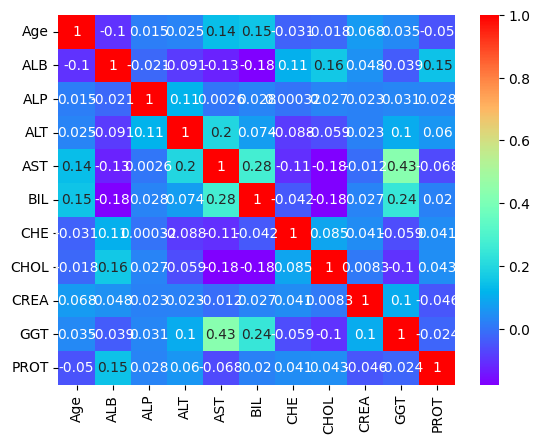

In [78]:
sns.heatmap(hcv.corr(), annot=True, cmap='rainbow')
# ALP CHOL

In [79]:
encoder = LabelEncoder()
hcv["Sex"] = encoder.fit_transform(hcv["Sex"])
hcv["Category"] = encoder.fit_transform(hcv["Category"])

In [80]:
hcv_target = hcv["Category"]
hcv.drop(columns=["Category"], inplace=True)

In [81]:
imputer = KNNImputer(n_neighbors=5).set_output(transform="pandas")
hcv = imputer.fit_transform(hcv)
hcv[hcv.isna().any(axis=1)]

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT


In [82]:
# hcv["Category"] = hcv_target
# sns.pairplot(hcv, hue="Category")
# hcv.drop(columns=["Category"], inplace=True)

<Axes: xlabel='lda2', ylabel='lda1'>

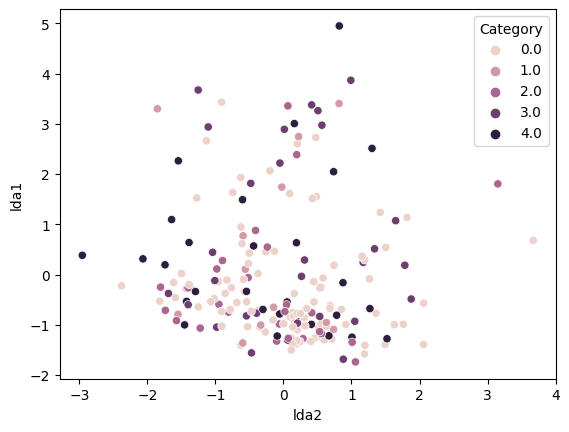

In [83]:
lda = LDA(n_components=2)
hcv_lda = pd.DataFrame(lda.fit_transform(hcv, hcv_target), columns=['lda1', 'lda2'])
sns.scatterplot(data=hcv_lda, x='lda2', y='lda1', hue=hcv_target)

<Axes: xlabel='pca1', ylabel='pca2'>

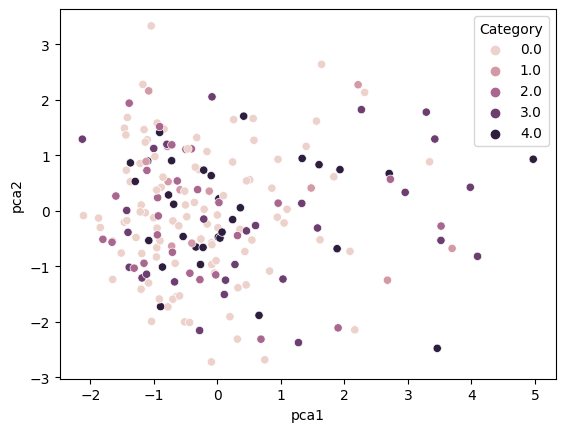

In [84]:

pca_pipeline = Pipeline(
    [
      ('scaler', StandardScaler()),
      ('pca_dim_reduction', PCA(n_components=2)),
    ]
)

hcv_pca = pd.DataFrame(pca_pipeline.fit_transform(hcv), columns = ['pca1', 'pca2'])
sns.scatterplot(data=hcv_pca, x='pca1', y='pca2', hue=hcv_target)